<a href="https://colab.research.google.com/github/KonstantinBurkin/Math_for_DS_exam/blob/main/math_for_DS_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [151]:
import numpy as np
import scipy.optimize as scopt
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax
from jax.config import config                       # нужно импортировать!
config.update("jax_enable_x64", True)               # нужно импортировать!

In [152]:
np.random.seed(0)

m = 100
n = 10
A = np.random.randn(m, n) # сгенерированная матрица
b = np.random.randn(m)    # сгенерированный вектор

x0 = jax.numpy.zeros(n)   # начальное приближение
eps = 1e-4                # точность расчета
alpha = 1e-4              # размер шага
num_iter = 2000           # максимальное количество итераций

In [153]:
f = lambda x: (jax.numpy.linalg.norm(A@x - b))**3
gradf = jax.grad(f)

In [154]:
def grad_descent(f, grad, x0, num_iter, eps, alpha):
    x = x0.copy()
    conv = [x]
    norm = []
    for i in range(num_iter):
        h = -grad(x)
        norm.append(np.linalg.norm(h))
        if jnp.linalg.norm(h) < eps:
            break
        x = x + alpha * h
        conv.append(x)
    return x, conv, i, norm

87
88


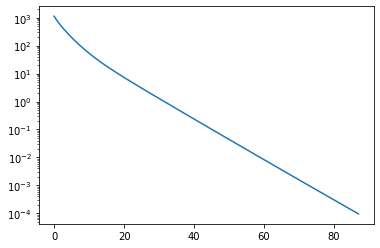

In [158]:
x_gd, conv_gd, i_gd, norm = grad_descent(f, gradf, x0, num_iter, eps, alpha)
print(i_gd)
print(len(conv_gd))
plt.semilogy([x for x in norm])

46
47


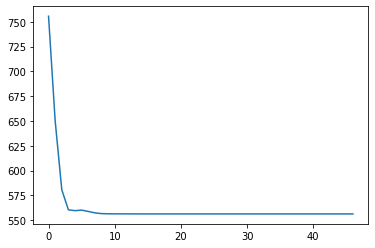

In [157]:
# все работает и правильный ответ с функцией:
# f = lambda x: (jax.numpy.linalg.norm(A@x - b))**3
def heavy_ball(f, grad, x0, num_iter, eps, alpha, beta):
    x = x0.copy()
    conv = [x.copy()]
    prev_x = None
    for i in range(num_iter):
        h = -grad(x)
        if jax.numpy.linalg.norm(h) < eps:
          break
        if prev_x is None:
            prev_x = x
            x = x + alpha * h
        else:
            x, prev_x = x + alpha * h + beta * (x - prev_x), x
        conv.append(x.copy())
    return x, conv, i

x_star, conv_gd, i = heavy_ball(f, gradf, x0, num_iter, eps, alpha, beta=0.5)
print(i)
print(len(conv_gd))
plt.plot([f(x) for x in conv_gd])